In [ ]:
"""
Purpose: To create functions that generate graphs through different
generative rules

For a specified number of edges and nodes

Types of Graphs will make:
1) Specified Degree Distribution: Poisson, Exponential, Powerlaw, Truncated power law, stretched exponential, lognormal, normal distribution
2) Preferential Attachment
a. More likely to connect if have higher degree (pick randomly )
b. " " but decreases probability with longer range connections
c. preferential attatchmnet but is wrapped with non-linear function of degree

3) Poor get richer
4) Preferential attachment by node property (orientation):
a. Randomly distributed nodes
b. Noisy pinwheel

5) Atttchment kernel that factors in other things

6) Vertex copying:
- with mutations (connecting to random edge)
- complentation (deleting the corresponding edge in the copied vertex with probability --> competition)

7) Network governed by optimization metric (global rule): 
    a. Start random --> then optimize network to local minimum using
    annealing
    
    b. Can optimize against 2 competing parameters


8) Random Growing (idea is that nodes added earlier will have more chances to be adjacent):
a. At i node is added
b. M/n edges are added uniformly at random

9) Preferential Attachment with dying nodes (at each time step):
- can pick node by any features (degree, inverse of degree)



Types of variations will add (will be sure and maintain the edge number):

Random Switching (wrapper)
Adding/Removal based on:
    - rich get richer
    - poor get richer
Long Range connection die off (preferrentially remove, preferentially add)

Merge Errors (higher likelihood if closer together in distance)
    - but how do we maintain node count?


Other additional features to measure:
1) Degree Distribution'
2) Number of components
3) Number of components if take top 10 % of betweeness ceentrality nodes
4) Top heavy: % of nodes that connect to top k % of degree nodes
5) Graph closure for nodes of high degree
6) Measure correlation of high degree nodes connecting to other high degree hodes
7) Size of large component and average size of small component
8) Average correlations in nodes

"""

# Graph Generation Functions (Already given)

In [ ]:
"""

# Those already created by networkx:
nx.duplication_divergence_graph
nx.powerlaw_cluster_graph(n, m, p, seed=None) #power-law with certain clustering
 --> just falls back on preferential attachment with added function for connectivity
nx.random_regular_graph# (UNIFORM) returns d_regular graph where d is the number of neighbors

d_G = nx.random_regular_graph(3,10)
nx.draw(d_G)
"""

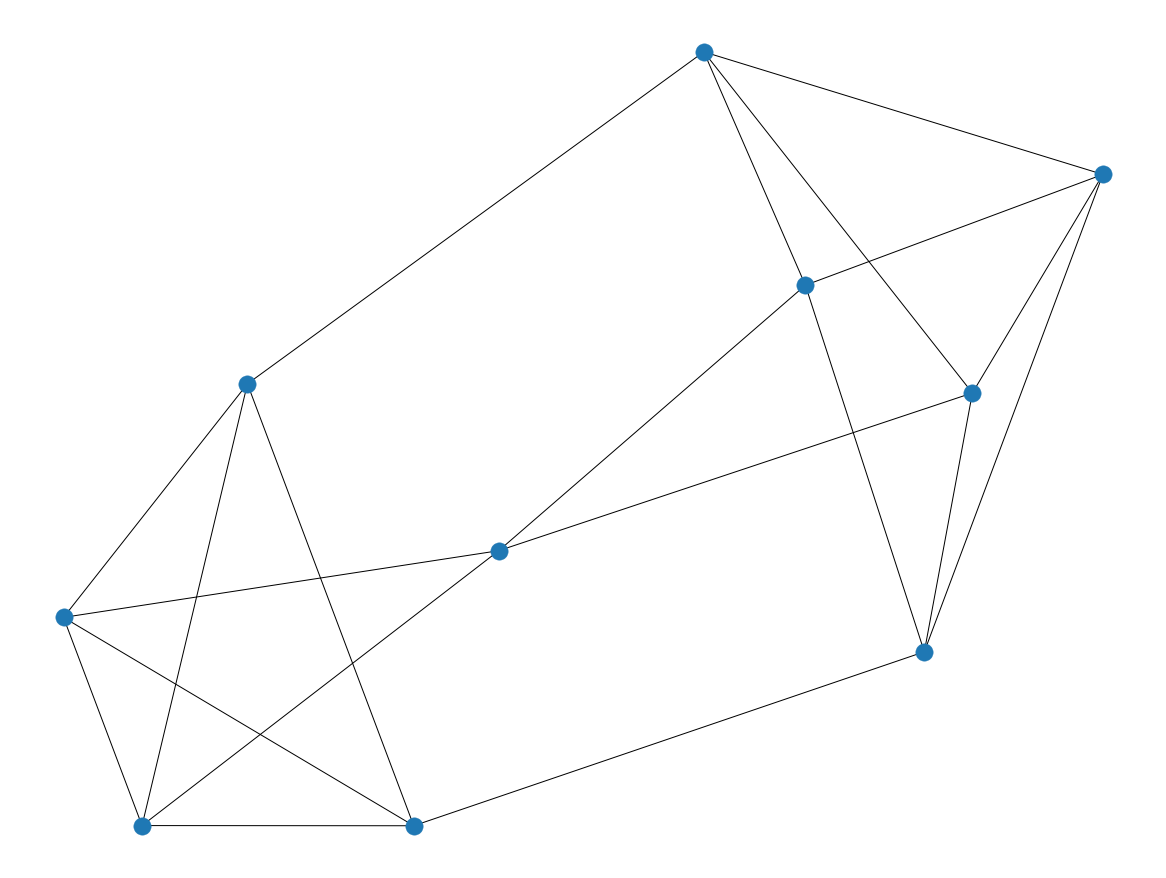

In [252]:
def random_uniform(n,k):
    return nx.random_regular_graph(k,n)

nx.draw(random_uniform(10,4))

# Aging Vertices (AGV) (like preferential attachment and small world)

# ---------------- PREFERENTIAL ATTACHMENT --------------------- #

# Preferential Attachmentn but starts from random graph

In [249]:
def linear_preferencial_attachment_random(n,m,p_start,G = None,seed=None):
    """
    Will generate a rich get richer graph
    
    Pseudocode:
    
    """
    if not G:
        G = nx.erdos_renyi_graph(m,p_start)
    
    targets = np.array(G.edges()).ravel()
    i = m
    #loop that will add the node
    while i < n:
        new_targets = np.random.choice(targets,m)
        G.add_edges_from(zip([i]*m,targets))
        targets = np.hstack([targets,new_targets])

        i += 1

    return G

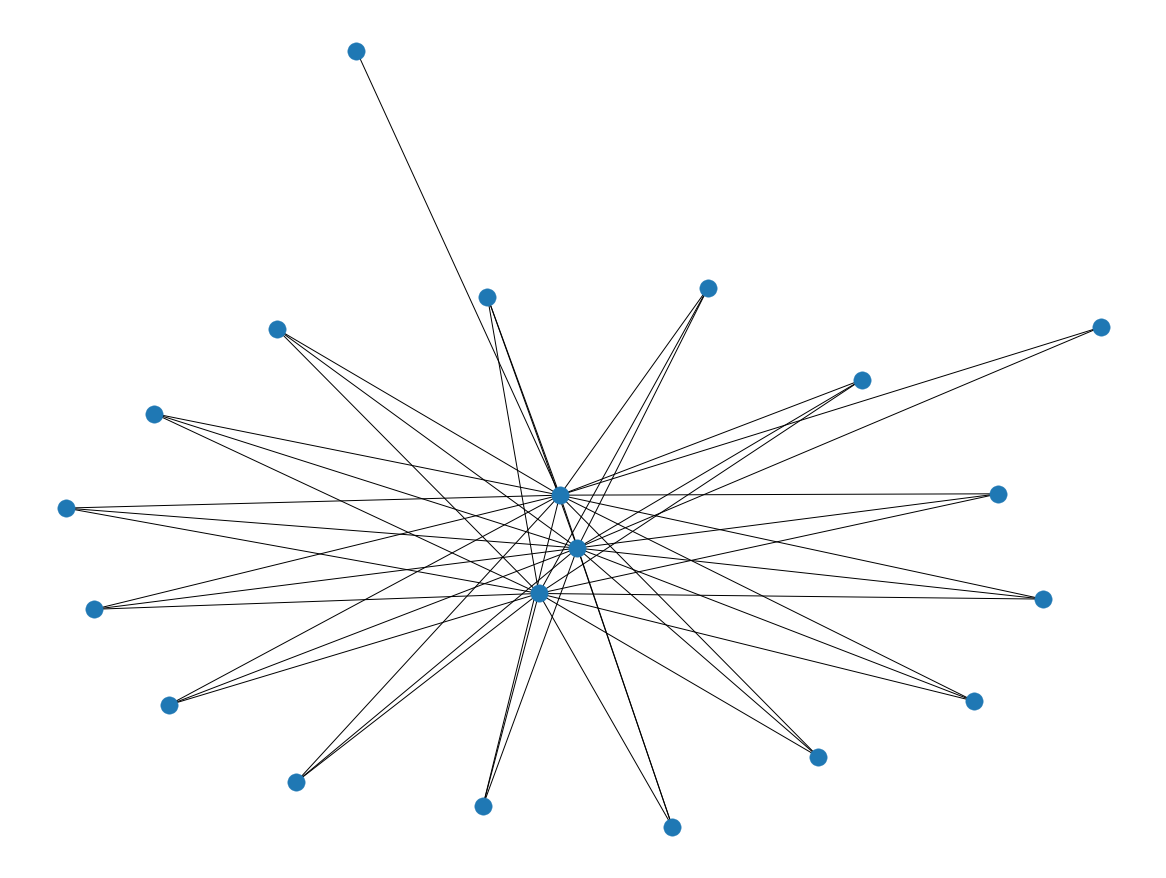

In [251]:
G_LPA = linear_preferencial_attachment_random(20,5,0.3)
nx.draw(G_LPA)

# Preferential Attachmentn but starts from spoke and wheel graph (barabasi_albert_graph)

In [227]:
def _random_subset(seq,m):
    """ Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.
    """
    targets=set()
    while len(targets)<m:
        x=random.choice(seq)
        targets.add(x)
    return targets

from networkx.generators.classic import empty_graph, path_graph, complete_graph
def linear_preferncial_attachment_wheel(n, m, seed=None):
    """Returns a random graph according to the Barabási–Albert preferential
    attachment model.

    A graph of ``n`` nodes is grown by attaching new nodes each with ``m``
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If ``m`` does not satisfy ``1 <= m < n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or  m >=n:
        raise nx.NetworkXError("Barabási–Albert network must have m >= 1"
                               " and m < n, m = %d, n = %d" % (m, n))
    if seed is not None:
        random.seed(seed)

    # Add m initial nodes (m0 in barabasi-speak)
    G=empty_graph(m)
    G.name="barabasi_albert_graph(%s,%s)"%(n,m)
    # Target nodes for new edges
    targets=list(range(m))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes=[]
    # Start adding the other n-m nodes. The first node is m.
    source=m
    while source<n: #because want to get all the way to n nodes and starting with m
        # Add edges to m nodes from the source to all of the targets
        G.add_edges_from(zip([source]*m,targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source]*m)
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        targets = _random_subset(repeated_nodes,m)
        source += 1
    return G

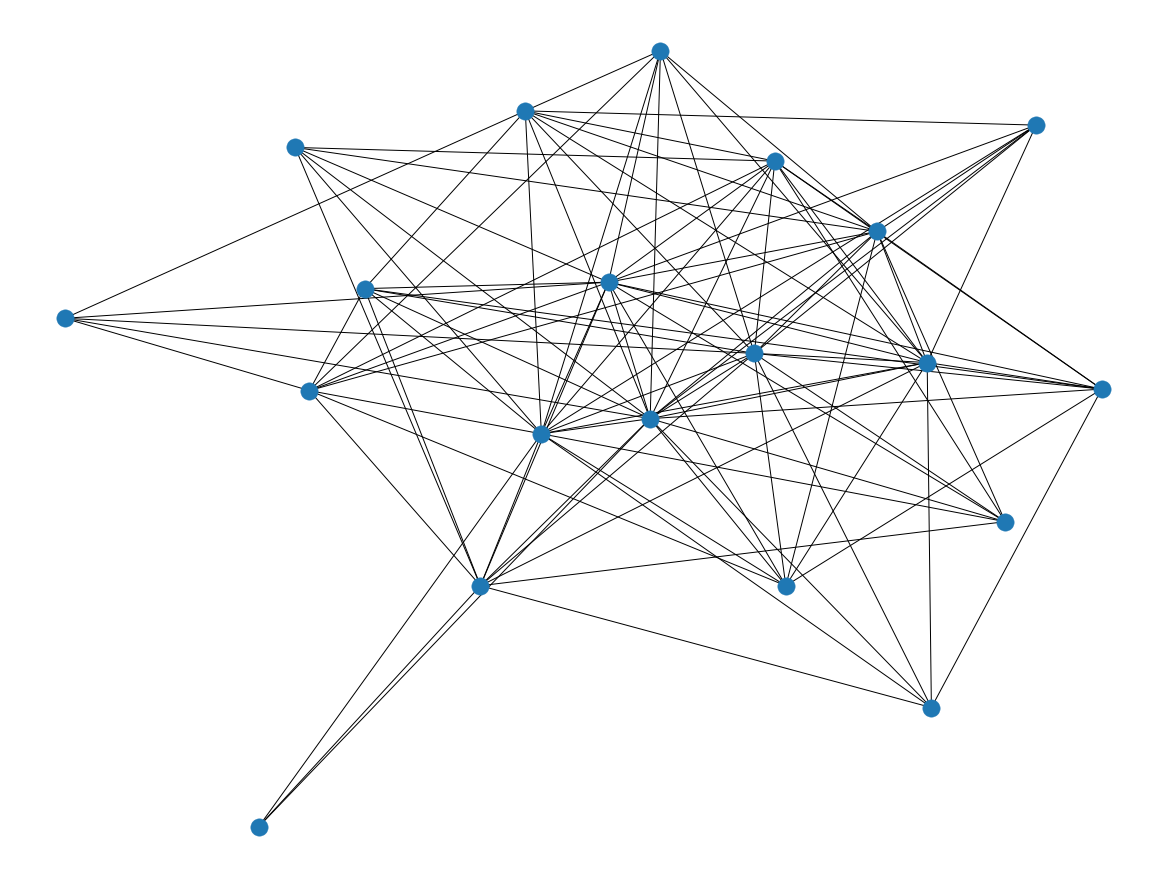

In [236]:
G = linear_preferncial_attachment_wheel(n=20, m=9, seed=None)
nx.draw(G)

# ------------ Vertex Duplication -------------------

In [264]:
# BASIC vertex duplication:
"""
How it works: 
1) Start with 2 nodes connected
2) Adds on node and decides to replicate

"""

import random
def vertex_duplication(n, p, seed=None):
    """Returns an undirected graph using the duplication-divergence model.

    A graph of ``n`` nodes is created by duplicating the initial nodes
    and retaining edges incident to the original nodes with a retention
    probability ``p``.

    Parameters
    ----------
    n : int
        The desired number of nodes in the graph.
    p : float
        The probability for retaining the edge of the replicated node.
    seed : int, optional
        A seed for the random number generator of ``random`` (default=None).

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `p` is not a valid probability.
        If `n` is less than 2.

    """
    if p > 1 or p < 0:
        msg = "NetworkXError p={0} is not in [0,1].".format(p)
        raise nx.NetworkXError(msg)
    if n < 2:
        msg = 'n must be greater than or equal to 2'
        raise nx.NetworkXError(msg)
    if seed is not None:
        random.seed(seed)

    G = nx.Graph()
    G.graph['name'] = "Duplication-Divergence Graph"

    # Initialize the graph with two connected nodes.
    G.add_edge(0,1)
    i = 2
    while i < n:
        # Choose a random node from current graph to duplicate.
        random_node = np.random.choice(G.nodes())
        # Make the replica.
        G.add_node(i)
        # flag indicates whether at least one edge is connected on the replica.
        flag=False
        for nbr in G.neighbors(random_node):
            if random.random() < p:
                # Link retention step.
                G.add_edge(i, nbr)
                flag = True

        
        # NOT GOING TO DELETE NODE FROM THE GROUP IF IT DOES NO EDGES
        if not flag:
            # Delete replica if no edges retained.
            G.remove_node(i)
        else:
            # Successful duplication.
            i += 1

    return G


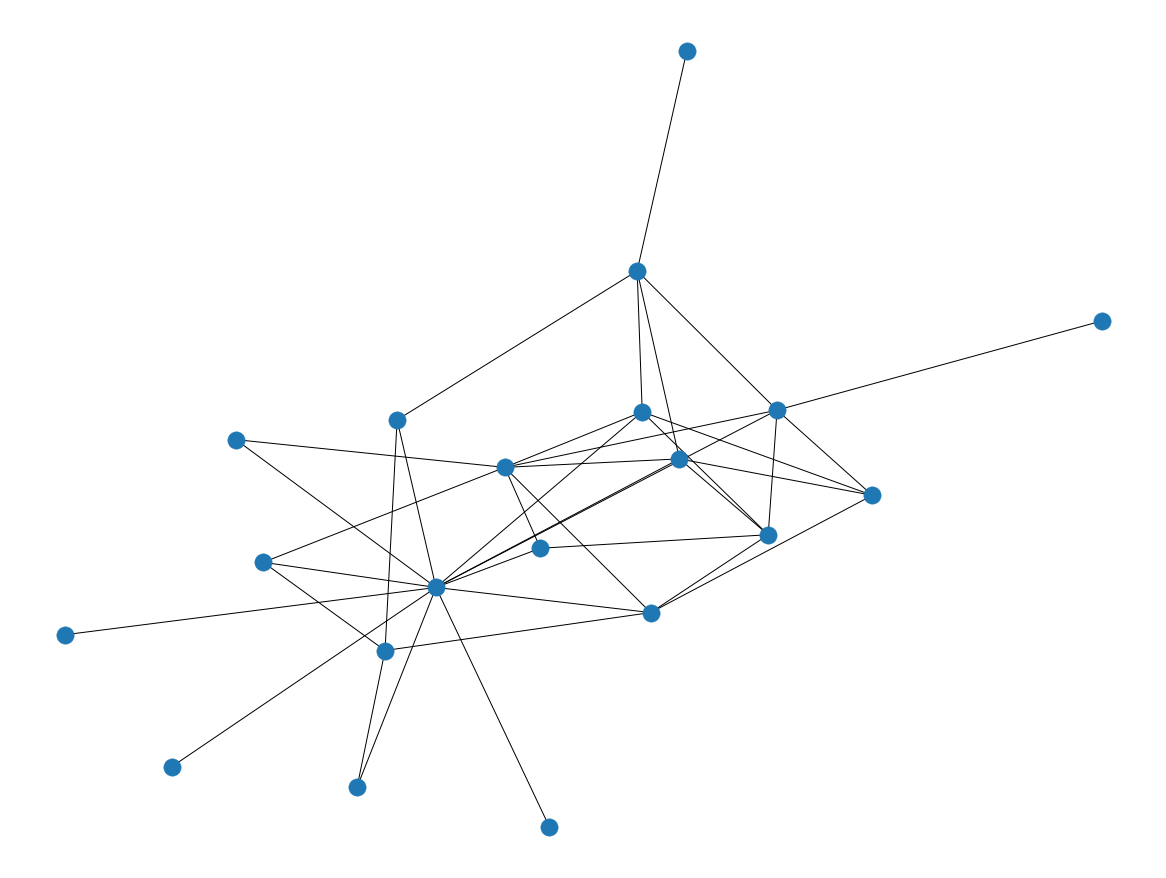

In [265]:
nx.draw(vertex_duplication(20,0.5))

# Vertex Duplication with RANDOM MUTATION

In [266]:
# vertex duplication WITH RANDOM MUTATION:
"""
How it works: 
1) Start with 2 nodes connected
2) Adds on node and decides to replicate

"""

import random
def vertex_duplication_with_mutation(n, p, p_mut, seed=None):
    """Returns an undirected graph using the duplication-divergence model.
    with probability p copies the edges of a node
    with probability (1-p makes random edge)

    """
    if p > 1 or p < 0:
        msg = "NetworkXError p={0} is not in [0,1].".format(p)
        raise nx.NetworkXError(msg)
    if n < 2:
        msg = 'n must be greater than or equal to 2'
        raise nx.NetworkXError(msg)
    if seed is not None:
        random.seed(seed)

    G = nx.Graph()
    G.graph['name'] = "Duplication-Divergence Graph (with Mutation)"

    # Initialize the graph with two connected nodes.
    G.add_edge(0,1)
    i = 2
    
    while i < n:
        # Choose a random node from current graph to duplicate.
        
        random_node = np.random.choice(G.nodes())
        # Make the replica.
        G.add_node(i)
        # flag indicates whether at least one edge is connected on the replica.
        flag= False
        random_node_neighbors = list(G.neighbors(random_node)).copy()
        for nbr in random_node_neighbors:
            if random.random() < p:
                # Link retention step.
                G.add_edge(i, nbr)
                flag = True
        """
        Alteration: 
        1) For all neighbors not connected to new node
        2) connect to them with probability p_mut/(i-1), so that it decays over time
        """
        
        #get all of the neighbors not connected to 
        current_neighbors = set(G.neighbors(i))
        remaining_neighbors = set(G.nodes()).difference(current_neighbors)
        
        for nbr in remaining_neighbors:
            if random.random() < p_mut/(i-1):
                # Link retention step.
                G.add_edge(i, nbr)
                flag = True
        
        

        # NOT GOING TO DELETE NODE FROM THE GROUP IF IT DOES NO EDGES
        if not flag:
            # Delete replica if no edges retained.
            G.remove_node(i)
        else:
            # Successful duplication.
            i += 1
    return G


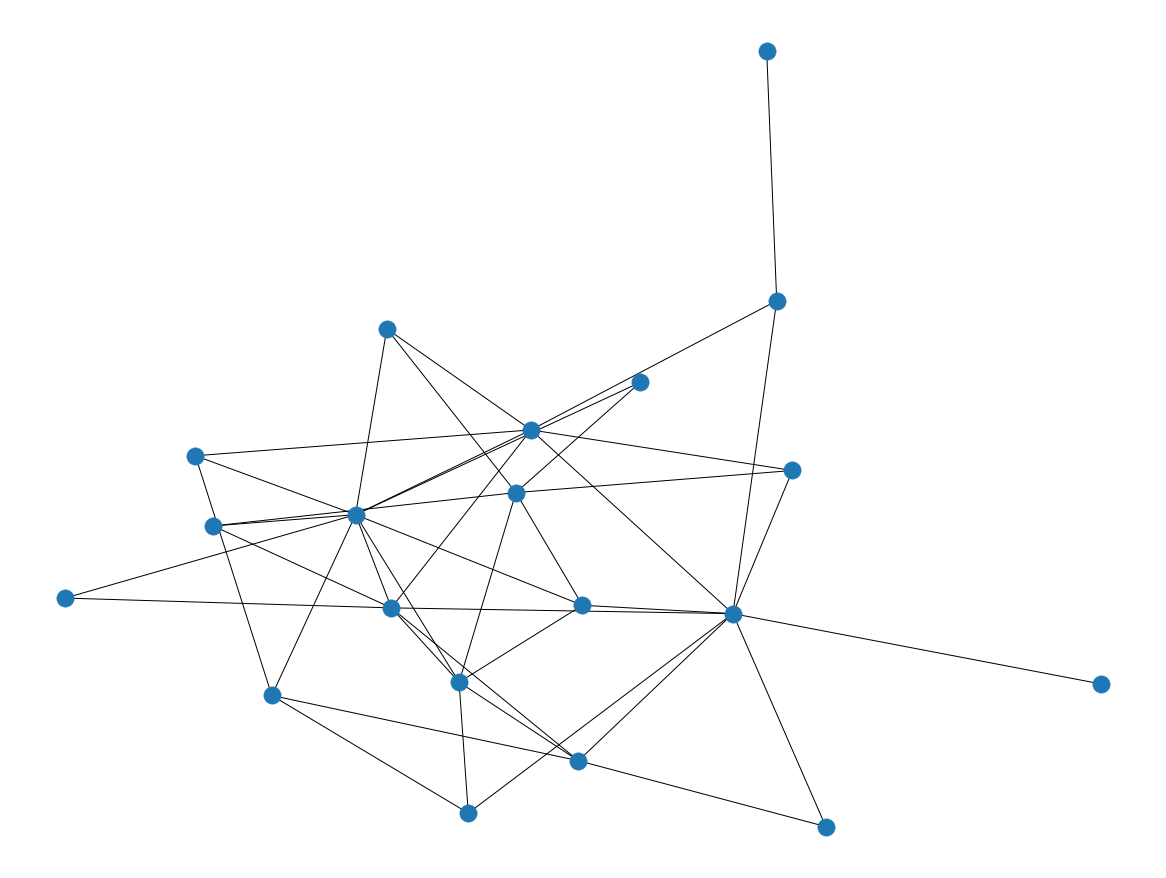

In [267]:
nx.draw(vertex_duplication_with_mutation(20,0.5,0.3))

# Vertex Duplication with Complementation

In [282]:
# vertex duplication WITH RANDOM MUTATION:
"""
How it works: 
1) Start with 2 nodes connected
2) Adds on node and decides to replicate

"""

import random
def vertex_duplication_with_complement(n, p, p_con, seed=None):
    """Returns an undirected graph using the duplication-divergence model.
    with probability p copies the edges of a node
    with probability (1-p makes random edge)

    """
    if p > 1 or p < 0:
        msg = "NetworkXError p={0} is not in [0,1].".format(p)
        raise nx.NetworkXError(msg)
    if n < 2:
        msg = 'n must be greater than or equal to 2'
        raise nx.NetworkXError(msg)
    if seed is not None:
        random.seed(seed)

    G = nx.Graph()
    G.graph['name'] = "Duplication-Divergence Graph (with Mutation)"

    # Initialize the graph with two connected nodes.
    G.add_edge(0,1)
    i = 2
    while i < n:
        # Choose a random node from current graph to duplicate.
        
        random_node = np.random.choice(G.nodes())
        # Make the replica.
        G.add_node(i)
        # flag indicates whether at least one edge is connected on the replica.
        flag= False
        random_node_neighbors = list(G.neighbors(random_node)).copy()
        for nbr in random_node_neighbors:
            if random.random() < p:
                # Link retention step.
                G.add_edge(i, nbr)
                flag = True
            else: #if decided not to have the edge copied, can actually still add the edge but eliminate original edge
                #decide with 50/50 shot of whether to add edge to new vertices
                #and delete the copied edge or keep everything the same
                if np.random.choice([0,1]):
                    G.remove_edge(random_node,nbr)
                    G.add_edge(i,nbr)
                    flag = True
                
                    
        #decide whether to connect the new vertex and the one we copied

        
        if np.random.choice([0,1],p=[(1-p_con),p_con]):
            G.add_edge(random_node,nbr)
            flag = True

        
#         # NOT GOING TO DELETE NODE FROM THE GROUP IF IT DOES NO EDGES
#         if not flag:
#             # Delete replica if no edges retained.
#             G.remove_node(i)
            
            
        #delete all nodes with 0    
        for nd in [k for k,v in G.degree() if v == 0]:
            G.remove_node(nd)
        
        #print(G.degrees())
        i = len(G.nodes())
        
    return G


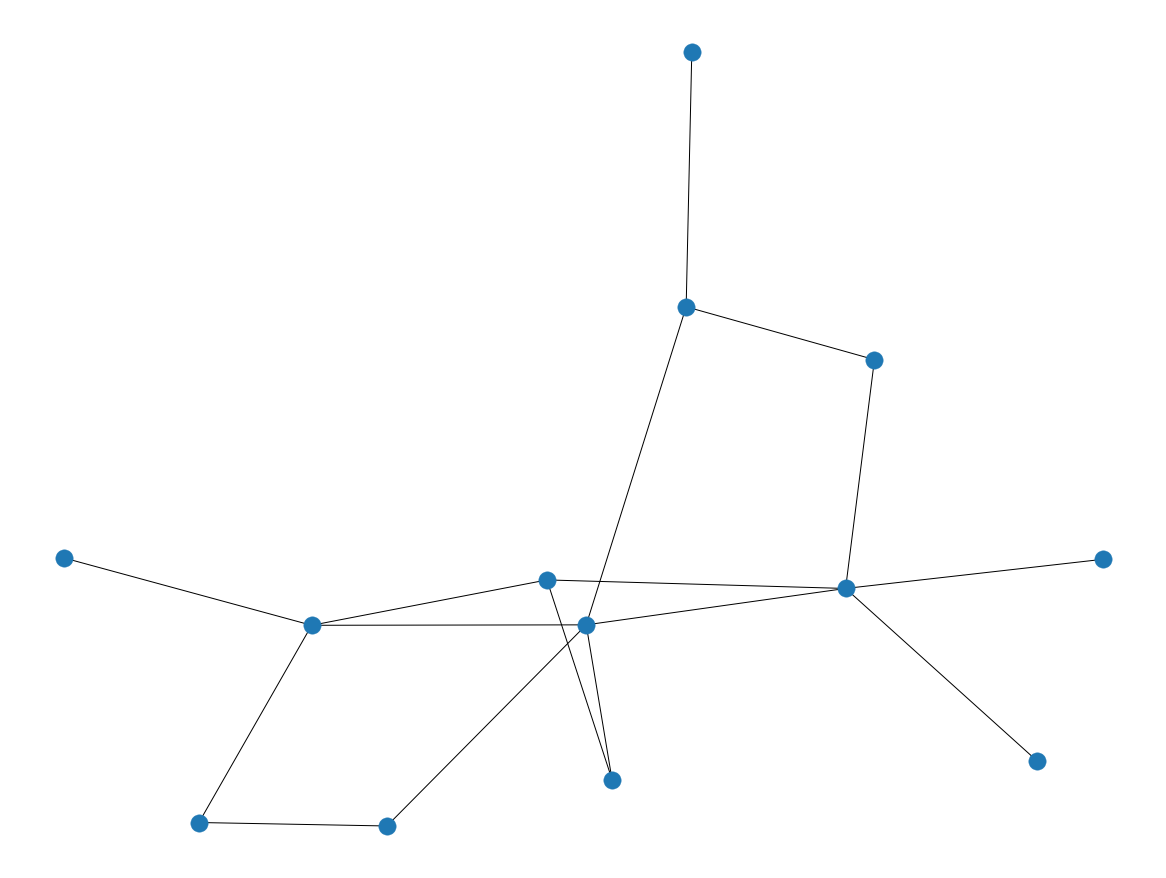

In [283]:
G_DWC = vertex_duplication_with_complement(n=13, p=0.5, p_con=0.9)
nx.draw(G_DWC)

# Graphs with Specific Degree Distribution

In [284]:
import numpy as np
import matplotlib
n = 1000
# x = np.random.power(-2,n)
# t = np.arange(0,n)




r = np.random.uniform(0,1,1000)
x = xmin * (1-r) ** (-1/(alpha-1))

Calculating best minimal value for power law fit


2.9796437286727757 0.03746531008886702 3.105162083325336
(519.1598115041659, 1.005114068372611e-16)


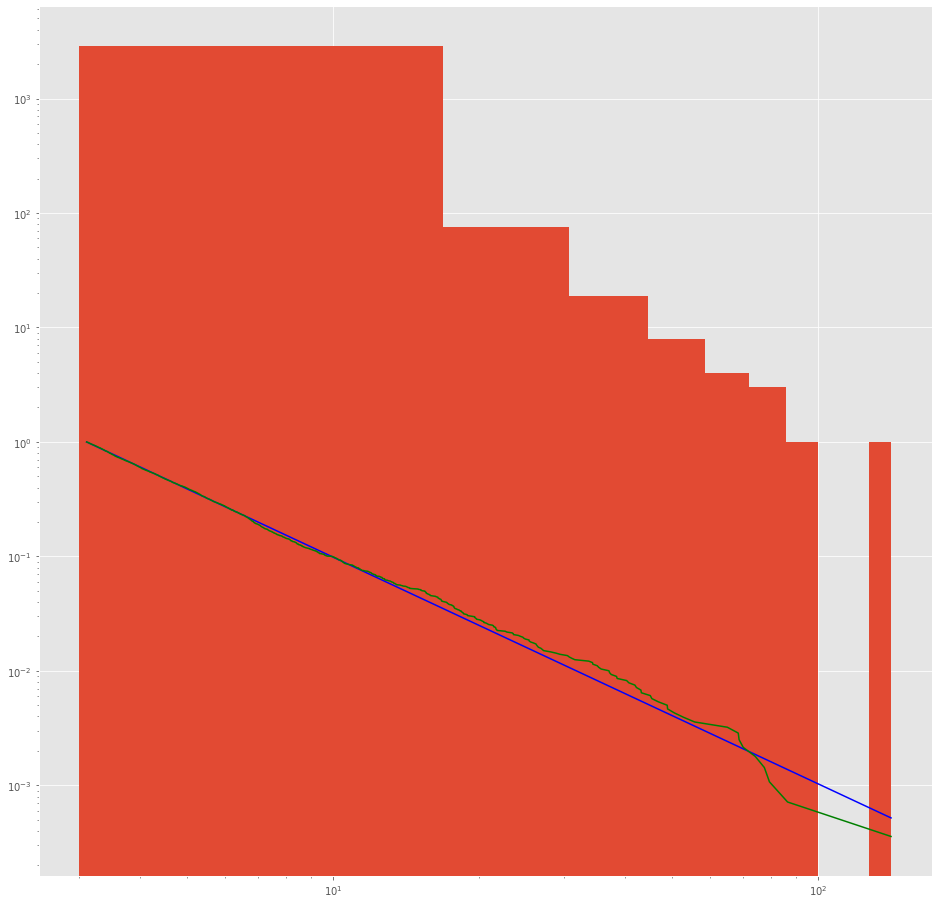

In [39]:
alpha = 3
xmin = 3
r = np.random.uniform(0,1,3000)
x = xmin * (1-r) ** (-1/(alpha-1))
fit = powerlaw.Fit(x)
print(fit.power_law.alpha, fit.power_law.sigma, fit.power_law.xmin)
print(fit.distribution_compare("power_law","exponential"))
f, ax = plt.subplots(figsize=(16,16))
ax.hist(x)
ax.set_yscale("log")
ax.set_xscale("log")

fit.power_law.plot_ccdf(ax = ax, color = "blue")
fit.plot_ccdf(ax = ax, color = "green")

# Generating Random Graph from a certain Sequence

In [288]:
"""
Different sequences to to make
"""

def power_law_sequence(n,alpha,xmin,before_xmin_func=None,perc_before_xmin=0,before_xmin_func_args=dict()):
    if perc_before_xmin <= 0:
        r = np.random.uniform(0,1,n)
        x = xmin * (1-r) ** (-1/(alpha-1))
        return x
    else:
        n_before = np.floor(perc_before_xmin*n)
        n_after = n - n_before
        
        r = np.random.uniform(0,1,n)
        x_after = xmin * (1-r) ** (-1/(alpha-1))
        
        x_before = before_xmin_func(before_xmin_func_args.update(dict(n=n_before)))
        
        x_total = np.hstack([x_before,x_after])
        return x_total
        

def uniform_sequence(n,k_max):
    """
    Return sample sequence of length n from a uniform distribution.
    """
    return np.random.uniform(0,k,n)


def create_degree_sequence(n, sfunction=None, max_tries=2000, **kwds):
    """ Attempt to create a valid degree sequence of length n using
    specified function sfunction(n,**kwds).

    Parameters
    ----------
    n : int
        Length of degree sequence = number of nodes
    sfunction: function
        Function which returns a list of n real or integer values.
        Called as "sfunction(n,**kwds)".
    max_tries: int
        Max number of attempts at creating valid degree sequence.

    Notes
    -----
    Repeatedly create a degree sequence by calling sfunction(n,**kwds)
    until achieving a valid degree sequence. If unsuccessful after
    max_tries attempts, raise an exception.
    
    For examples of sfunctions that return sequences of random numbers,
    see networkx.Utils.

    Examples
    --------
    >>> from networkx.utils import uniform_sequence, create_degree_sequence
    >>> seq=create_degree_sequence(10,uniform_sequence)
    """
    tries=0
    max_deg=n
    while tries < max_tries:
        trialseq=sfunction(n=n,**kwds)
        # round to integer values in the range [0,max_deg]
        seq=[min(max_deg, max( int(round(s)),0 )) for s in trialseq]
        #if graphical return, else throw away and try again
        #if sum(seq) % 2 == 0:
        if nx.is_graphical(powerlaw_degree_seq):
            print("returning a sequence that can be exactly build")
            return seq
        tries+=1
    tries = 0
    while tries < max_tries:
        trialseq=sfunction(n=n,**kwds)
        # round to integer values in the range [0,max_deg]
        seq=[min(max_deg, max( int(round(s)),0 )) for s in trialseq]
        #if graphical return, else throw away and try again
        if sum(seq) % 2 == 0:
        #if nx.is_graphical(powerlaw_degree_seq):
            print("Couldn't find exact sequence, return even sequence")
            return seq
        tries+=1
    raise nx.NetworkXError(\
          "Exceeded max (%d) attempts at a valid sequence."%max_tries)

In [291]:
nx.generators.degree_seq.random_degree_sequence_graph #has the exact same sequence as that passed
nx.generators.degree_seq.expected_degree_graph #has the same expected degree as the sequene passed

powerlaw_degree_seq = create_degree_sequence(n = 40, sfunction=power_law_sequence, max_tries=50, xmin = 1,alpha=2)

Couldn't find exact sequence, return even sequence


Using Random location because the current location keys did not match those of the nodes for graph 0
2.7219192373178505 0.3514852924759257 (6.008981917983941, 0.03139422147440926)


Calculating best minimal value for power law fit


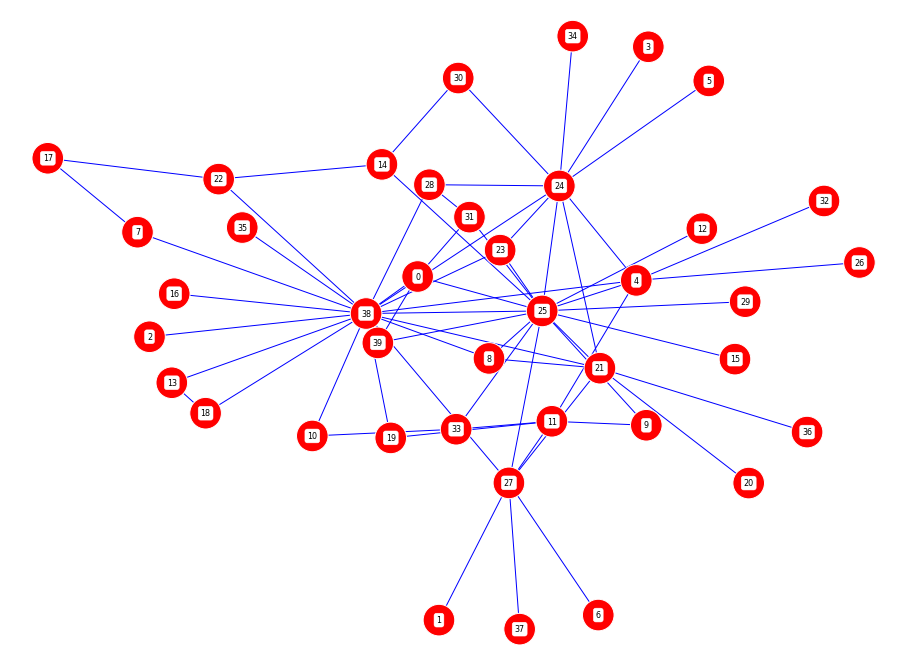

In [292]:
"""
Functions that will approximate a certain discrete degree distribution
for its function


"""

import networkx as nx

G=nx.configuration_model(powerlaw_degree_seq)

G=nx.Graph(G) # to remove parallel edges
G.remove_edges_from(G.selfloop_edges()) # to remove self loops

import graph_experiments_utils as gu


fig = gu.graph_network_matplotlib(G,plot_type="2D",
                                          colors="red",
                                         colors_edge = "blue",
                                            node_size = 64,
                                       node_label_size=10,
                                       return_fig=True)

total_degrees = np.array(G.degree())[:,1]
config_fit = powerlaw.Fit(total_degrees)
print(config_fit.power_law.alpha,config_fit.power_law.sigma,config_fit.distribution_compare("power_law","exponential"))

# New Satistics Measurements

In [7]:
"""
Package that will help with powerlaw calculations: https://github.com/jeffalstott/powerlaw

"""

import powerlaw
fit = powerlaw.Fit([10,10,10,4,5,6,3,4,3,3,3])
fit.supported_distributions
fit.power_law.alpha, fit.power_law.sigma, fit.power_law.xmin

Calculating best minimal value for power law fit


(3.0403411192706598, 0.6151859942685958, 3.0)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/hist.py:62: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


KeyboardInterrupt: 

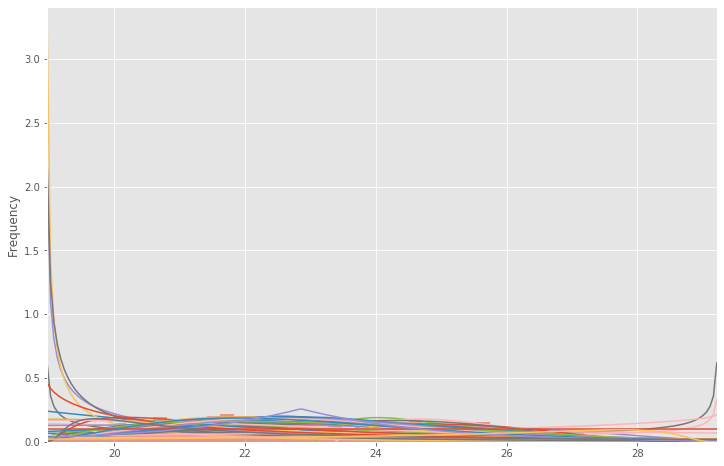

In [2]:
"""
How to fit different distributions with scipy
"""

%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function for anyone that you pass it """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

# Graph Measurements

In [ ]:
nx.number_connected_components
np.mean(nx.rich_club_coefficient)

# Node Similarity Meausrements

In [ ]:
"""
In the link prediction: https://networkx.github.io/documentation/stable/reference/algorithms/link_prediction.html
"""

In [118]:
"""
Node centralities
"""

nx.betweenness_centrality
nx.katz_centrality
nx.eigenvector_centrality
nx.closeness_centrality
nx.pagerank
nx.hits #returns the hubs and authorities of matrix
rich_club_coefficient # percentage of how many nodes it connects to that are greater than it

<function networkx.algorithms.centrality.betweenness.betweenness_centrality(G, k=None, normalized=True, weight=None, endpoints=False, seed=None)>